# Assignment 3
## By - Sanchana Mohankumar

# Libraries

In [ ]:
!pip install emoji
!pip install sweetviz

In [402]:
#Libraries
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import re

#library to remove emoji
from emoji import demojize

#libraries for plots
import matplotlib.pyplot as plt
import seaborn as sns

#nltk libraries

import nltk
nltk.download('omw-1.4')
#extracting punctuation and adding to list
from string import punctuation 
#Custom Punctuation
custom_punc = ',“”"!#$%&\'()*+-\./:;<=>?@[\\]^_`{|}~—ー‘’•–'

#word and sentence tokenize
import nltk.data
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import WordPunctTokenizer  # tokenizes punctuation also
tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle') #sentence tokenizer

#keras
from keras.preprocessing.text import text_to_word_sequence # tokenizes and removes punctuation

#Downloading nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from gensim.parsing.preprocessing import remove_stopwords

#Stemming
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

#Lemmatizing
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#Padding
import tensorflow as tf
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences

#Bag of words(Count vectorizer)
from sklearn.feature_extraction.text import CountVectorizer

#Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()

#svm model
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Bidirectional
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


#Bi LSTM Attention Layer
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import Data

In [305]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [386]:
text1 = pd.read_csv("/content/drive/MyDrive/Assignment_3/spam.csv")

In [387]:
class spamham:
      def __init__(self, dataframe):
          self.dataframe = dataframe

      def eda(self):
           ax = sns.countplot(x = 'label', data = self.dataframe, palette = 'magma')
           for p in ax.patches:
               ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
               ax.set(title = "Message data")
           return ax
        
      def sentence_preprocess(self, word):
           """ Sentence Preprocessing
        
           Returns:
           List of sentences in each tweet
           """
           word = word.lower()
           word = re.sub(r"\b[0-9]+\b\s*", "",word) # Remove numbers
           word = re.sub(r"https?://\S+", "", word) # Remove hyperlinks
           word = re.sub(f"[{re.escape(custom_punc)}]", "", word) #Remove punctuation
           word = demojize(word) # Remove emoji
           word = word.split() 
           word = [t for t in word if not t in stop_words] # Remove stopwords
           word = [lemmatizer.lemmatize(text) for text in word] #word lemmatize
           word = ' '.join(word)
           return word

      def clean_text(self):
           self.dataframe['clean_text'] = self.dataframe['text'].apply(lambda x: self.sentence_preprocess(x))
           return self.dataframe['clean_text'] #returning clean text after data preprocessing column text
      
      def encode_ylabel(self):
           self.dataframe['encoded_label'] = self.dataframe['label'].replace(['spam','ham'],[0, 1])
           return self.dataframe['encoded_label'] #returning encoded_label after converting spam to 0 and ham to 1

      def tokenize_padding(self):
           token = Tokenizer() #Initialize the tokenizer (set here so all of the datasets are in the same tokenizer)
           token.fit_on_texts(self.clean_text())
           print("vocab_size:", len(token.word_index) + 1)
           texts = token.texts_to_sequences(self.clean_text()) #Convert the tweets into sequences for keras to use
           texts = pad_sequences(texts, padding='post', maxlen = 100)
           self.dataframe["messageSequence"] = list(texts)
           return self.dataframe["messageSequence"]

      def show_performance_plot(self, x):
          #show the model accuracy
          plt.plot(history.history['accuracy'])
          plt.plot(history.history['val_accuracy'])

          plt.title('model accuracy')
          plt.ylabel('accuracy')
          plt.xlabel('epoch')
          plt.legend(['train','test'], loc='upper left')
          plt.show()

          #show model loss
          plt.plot(history.history['loss'])
          plt.plot(history.history['val_loss'])

          plt.title('model loss')
          plt.ylabel('loss')
          plt.xlabel('epoch')
          plt.legend(['train','test'], loc='upper left')
          plt.show()

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

      
p1 = spamham(text) 

# EDA
As we know in modern world we use social network for regularly, but with fast pace world when we come across spam notifications we tend to not notice spam notifications which is huge cybersecurity threat

- Dataset shows around 4825 ham and 747 spam data

As we can see in the below plot the distribution of data is inconsistent which may lead to poor model performance 

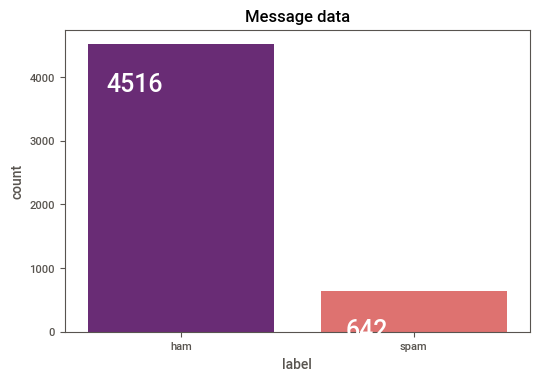

In [388]:
p1.eda()

### Dataframe shape
Dataframe review has 5572 rows and 2 columns

In [389]:
text1.shape

(5572, 2)

### Info
General information of dataset As we can see there are no missing data

In [390]:
text1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Dropping Duplicates

In [391]:
text = text1.drop_duplicates()
text.shape

(5158, 2)

In [392]:
import sweetviz as sv
report = sv.analyze(text)
report.show_html("output.html")

                                             |          | [  0%]   00:00 -> (? left)

Report output.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Text Preprocessing


Raw data exported from dataframe which consist of column Text and label

In [393]:
text.head()  # Raw data 

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


- Data is preprocessed where we have executed the following commands on column text
1. Removed Numbers
2. Removed Hyperlinks
3. Removed Punctuation
4. Removed stopwords
5. Removed emoji
6. Lemmatized words
- Further for column label we have encoded spam as 0 and ham as 1

In [394]:
p1.clean_text().head() # Data Preprocessed 

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts 21s...
3                  u dun say early hor u c already say
4             nah dont think go usf life around though
Name: clean_text, dtype: object

In [395]:
p1.encode_ylabel().head() #Encoded label column 

0    1
1    1
2    0
3    1
4    1
Name: encoded_label, dtype: int64

In [396]:
p1.dataframe.head()

,label,text,clean_text,encoded_label
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,1
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts 21s...,0
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though,1


# Part 1 

# Train Test Split
Over here we are splitting training data set and test data by 70% and 30%

In [397]:
x = p1.clean_text().values # Extracting encoded_label for y values
y = p1.encode_ylabel().values # Extracting text for x values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1, test_size = 0.30)

In [398]:
print('Lenght of train data', len(x_train),'| Lenght of test data', len(x_test))

Lenght of train data 3610 | Lenght of test data 1548


# Count Vectorizer
In order to perform bag of words we use count vectorizer
- https://www.educative.io/answers/countvectorizer-in-python


In [399]:
vectorizer = CountVectorizer(binary = True)
vectorizer.fit(list(x_train) + list(x_test))

x_train_vec = vectorizer.transform( x_train)
x_test_vec = vectorizer.transform( x_test)

Mapping of words to feature indices 

In [365]:
#vectorizer.vocabulary_

As we can see here we have 3900 featues and 8212 words in training dataset followed by 1672 features and 8212 words in test dataset 

In [400]:
vector = vectorizer.transform(x_train)
vector1 = vectorizer.transform(x_test)
print(vector.shape)
print(vector1.shape)

(3610, 8212)
(1548, 8212)


# SVM Model
Implementing SVM model
- As we can see through svm model we are getting an accuracy of 98% which says our model is performing really well

https://scikit-learn.org/stable/modules/svm.html

In [403]:
#classify using support vector classifier
svm = svm.SVC(kernel = 'linear', probability = True)

#Fit the svc model on the training data
prob = svm.fit(x_train_vec, y_train).predict_proba(x_test_vec)

y_pred_svm = svm.predict(x_test_vec)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91       186
           1       0.98      1.00      0.99      1362

    accuracy                           0.98      1548
   macro avg       0.98      0.93      0.95      1548
weighted avg       0.98      0.98      0.98      1548



# Part 2

### Tokenize and Padding

Over here we are tokenizing each word in a sentence and converting into sequences followed by performing padding to equalize the length of vectors in each row of the dataframe by adding 0 in empty column and setting max leghth to fiz the size of vectors 

In [404]:
p1.tokenize_padding().head()

vocab_size: 8275


0    [6, 3350, 247, 523, 559, 977, 41, 58, 312, 978...
1    [9, 204, 1109, 313, 1, 1464, 0, 0, 0, 0, 0, 0,...
2    [11, 400, 980, 800, 131, 2273, 1110, 560, 2274...
3    [1, 132, 56, 242, 2276, 1, 79, 69, 56, 0, 0, 0...
4    [741, 7, 33, 6, 682, 96, 112, 326, 0, 0, 0, 0,...
Name: messageSequence, dtype: object

In [405]:
p1.dataframe.head()

,label,text,clean_text,encoded_label,messageSequence
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,1,"[6, 3350, 247, 523, 559, 977, 41, 58, 312, 978..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,1,"[9, 204, 1109, 313, 1, 1464, 0, 0, 0, 0, 0, 0,..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts 21s...,0,"[11, 400, 980, 800, 131, 2273, 1110, 560, 2274..."
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,1,"[1, 132, 56, 242, 2276, 1, 79, 69, 56, 0, 0, 0..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though,1,"[741, 7, 33, 6, 682, 96, 112, 326, 0, 0, 0, 0,..."


### Train Test split

After we are done with padding and tokenizing we are spliiting the message Sequence column into train and test dataset by 70% and 30%
- Before peforming split we are inserting all the lists inside a single list 
- Mounting the list into a single array in order to pass it into our models further

In [406]:
# Extract encoded label 
y = list(p1.dataframe['encoded_label'])
x = list(p1.dataframe['messageSequence'])

x_final = np.array(x)
y_final = np.array(y)

# Split text data into 30 percent test data and 70 percent train data 
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, random_state = 1, test_size = 0.30)

### Golve Pretrained Model

As we see we are using a glove pretrained model for our dataset when in our case we can also perform onehot encoding to perform neural net models as we have less data but over here we are trying to do with pretrained word embedding models 

In [407]:
embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/Assignment_3/glove.6B.100d.txt',encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((8275, 100)) #This matrix will have 100 rows

token = Tokenizer()
token.fit_on_texts(p1.clean_text())

for word, index in token.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### LSTM Model
1. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
https://analyticsindiamag.com/
2. https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/#:~:text=Bidirectional%20long%2Dshort%20term%20memory,forward(past%20to%20future).

In [408]:
modelLSTM = Sequential()
embedding_layer = Embedding(8275, 100, weights=[embedding_matrix], input_length = 100 , trainable=False)
modelLSTM.add(embedding_layer)
modelLSTM.add(LSTM(128))
modelLSTM.add(Dense(1, activation='sigmoid'))
modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(modelLSTM.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 100)          827500    
                                                                 
 lstm_25 (LSTM)              (None, 128)               117248    
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 944,877
Trainable params: 117,377
Non-trainable params: 827,500
_________________________________________________________________
None


In [ ]:
history = modelLSTM.fit(x_train, y_train, batch_size=128, epochs=13, verbose=1, validation_split=0.2)
scoreTest = modelLSTM.evaluate(x_test, y_test, verbose=1)

In [374]:
print("Test Score:", scoreTest[0])
print("Test Accuracy:", scoreTest[1])

Test Score: 0.10589306056499481
Test Accuracy: 0.9677002429962158


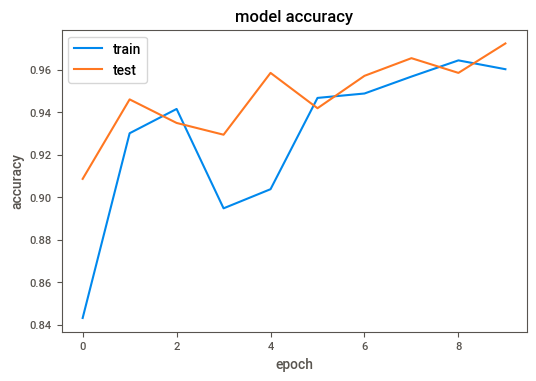

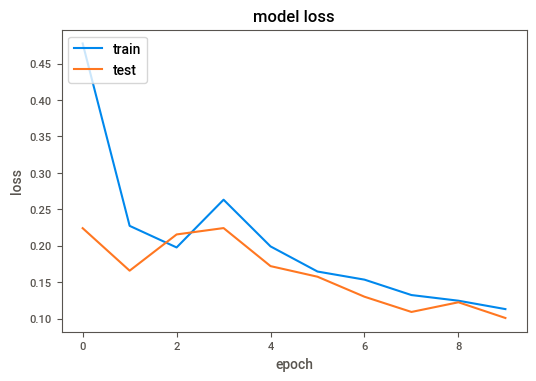

In [375]:
p1.show_performance_plot(history)

### Bi-LSTM Model
This kind of network can be used in text classification, speech recognition and forecasting models.

In [376]:
modelBiLSTM = Sequential()
embedding_layer = Embedding(8275, 100, weights=[embedding_matrix], input_length = 100 , trainable=False)
modelBiLSTM.add(embedding_layer)
modelBiLSTM.add(Bidirectional(LSTM(128)))
modelBiLSTM.add(Dropout(0.5))
modelBiLSTM.add(Dense(1, activation='sigmoid'))
modelBiLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelBiLSTM.summary()) 

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 100)          827500    
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              234496    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,062,253
Trainable params: 234,753
Non-trainable params: 827,500
_________________________________________________________________
None


In [ ]:
history1 = modelBiLSTM.fit(x_train, y_train, batch_size=128, epochs=13, verbose=1, validation_split=0.2)
scoreTest1 = modelBiLSTM.evaluate(x_test, y_test, verbose=1)

In [378]:
print("Test Score:", scoreTest1[0])
print("Test Accuracy:", scoreTest1[1])

Test Score: 0.10048335790634155
Test Accuracy: 0.973514199256897


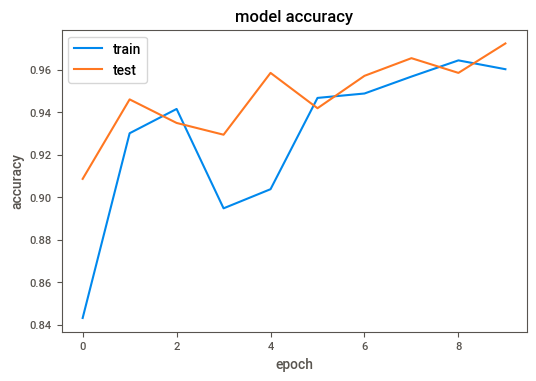

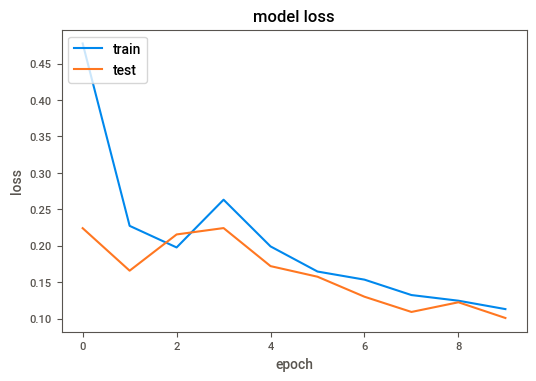

In [379]:
p1.show_performance_plot(history1)

## Bi-LSTM with activation Layer 

In [380]:
modelatt = Sequential()
modelatt.add(Embedding(8275, 100, weights=[embedding_matrix] , input_length= 100, trainable=False))
modelatt.add(Bidirectional(LSTM(32, return_sequences=True)))
modelatt.add(Attention(return_sequences=True)) # receive 3D and output 3D
modelatt.add(LSTM(32))
modelatt.add(Dense(1, activation='sigmoid'))
modelatt.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(modelatt.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 100, 100)          827500    
                                                                 
 bidirectional_12 (Bidirecti  (None, 100, 64)          34048     
 onal)                                                           
                                                                 
 attention_7 (Attention)     (None, 100, 64)           164       
                                                                 
 lstm_24 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 874,161
Trainable params: 46,661
Non-trainable params: 827,500
__________________________________________

In [ ]:
history2 = modelatt.fit(x_train, y_train, batch_size=128, epochs=13, verbose=1, validation_split=0.2)
scoreTest2 = modelatt.evaluate(x_test, y_test, verbose=1)

In [382]:
print("Test Score:", scoreTest2[0])
print("Test Accuracy:", scoreTest2[1])

Test Score: 0.27030855417251587
Test Accuracy: 0.7655038833618164


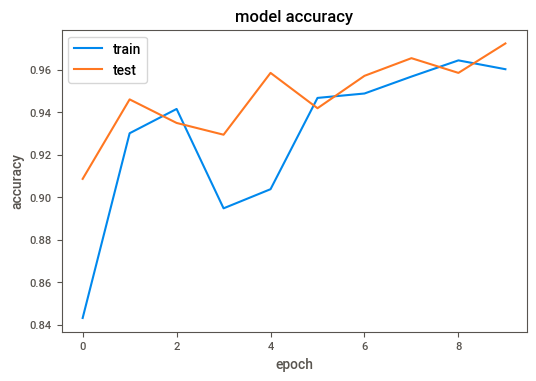

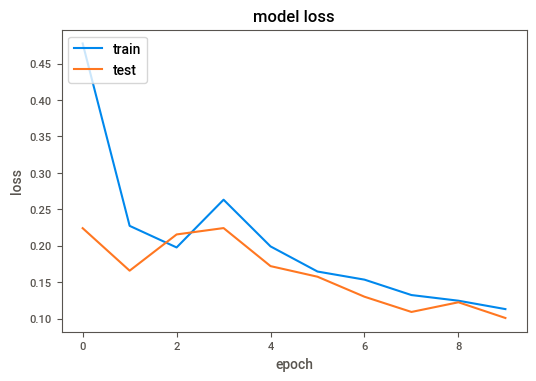

In [384]:
p1.show_performance_plot(history2)

On Running 
1. SVM model - using Count Vectorizer - getting an accuracy of 98%

2. LSTM model - using glove word embedding technique 
- Accuracy = 0.96, Loss = 0.11 | Validation_accuracy = 0.97, Loss = 0.10
3. Bi-LSTM model - using glove word embedding technique 
- Accuracy = 0.98, Loss = 0.06 | Validation_accuracy = 0.97, Loss = 0.09 
3. Bi-LSTM model with attention - using glove word embedding technique 
- Accuracy = 0.92, Loss = 0.16 | Validation_accuracy = 0.92 ,Loss = 0.23


- As per the results I would go with Bi-lstm model as it gives better accuracy and lesser loss rate in neural net and svm under ML algorithm gives a better accuracy

Insights 
- Not removing duplicates makes a significant difference in accuracy(decreases)
- We can do lstm without using pretrained model as we have lesser data

Productionalizing my model 
- Data Storage and Retrivel - As I have less data I wont opt for any cloud storage or issues related to large data 
- Selecting Tools and framework to  use and research on best tool to use(like how many platform suppot the tool)
- Checking the popularity of the tool to use the latest one
- By getting feedback from model once its implemeted production system in order to look for any perforamce issues

